In [1]:
%load_ext autoreload
%autoreload 2
# imports

import pacsltk.pacs_util as pacs_util
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

pacs_util.prepare_matplotlib_cycler()

# To avoid type 3 fonts: http://phyletica.org/matplotlib-fonts/
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import parse_util

import os
import glob
from datetime import timedelta

import pacsltk
print(pacsltk.__version__)

0.2.0


In [2]:
# Config paths
# EXP_CONFIG_NAME_DEFAULT = 'bench1_sleep_rand2_1000_200'
# EXP_CONFIG_NAME_DEFAULT = 'autoscale_go_500_10k_5'
# EXP_CONFIG_NAME_DEFAULT = 'autoscale_go_500_10k_5_rps'
EXP_CONFIG_NAME_DEFAULT = 'bench1_cpu_io_rps'
exp_config_name = os.getenv("EXP_CONFIG_NAME", EXP_CONFIG_NAME_DEFAULT)
exp_file = f"configs/{exp_config_name}.json"
overview_file_glob = f"results/{exp_config_name}/overview*.csv"
overview_file = glob.glob(overview_file_glob)[0]

print('config name:', exp_config_name)
print('overview file:', overview_file)
print('experiment file:', exp_file)

config name: bench1_cpu_io_rps
overview file: results/bench1_cpu_io_rps/overview_res-2021-03-17_12-59-06.csv
experiment file: configs/bench1_cpu_io_rps.json


In [3]:
# get overview
overview_df = pd.read_csv(overview_file, index_col=0, parse_dates=True)
overview_df.head(8)

,target,rps,res_name,request_func,workload_name,is_rps,exp_time_mins
0,1,1,res-2021-03-15_13-23-54,bench1_cpu_io_rps,bench1,True,60
1,1,2,res-2021-03-15_14-24-39,bench1_cpu_io_rps,bench1,True,60
2,1,3,res-2021-03-15_15-25-14,bench1_cpu_io_rps,bench1,True,60
3,1,5,res-2021-03-15_16-25-38,bench1_cpu_io_rps,bench1,True,60
4,1,7,res-2021-03-15_17-25-58,bench1_cpu_io_rps,bench1,True,60
5,1,10,res-2021-03-15_18-26-20,bench1_cpu_io_rps,bench1,True,60
6,1,15,res-2021-03-15_19-26-36,bench1_cpu_io_rps,bench1,True,60
7,1,20,res-2021-03-15_20-26-53,bench1_cpu_io_rps,bench1,True,60


In [4]:
# merge results of logger results
df_logger_merged = pd.DataFrame()
df_reqs_merged = pd.DataFrame()
for res_name in tqdm(overview_df['res_name']):
    res_logger_file = f"results/{exp_config_name}/{res_name}_logger.csv"
    df = parse_util.parse_logger_file(res_logger_file)
    df_logger_merged = df_logger_merged.append(df)

    res_reqs_file = f"results/{exp_config_name}/{res_name}_reqs.csv"
    df_req = parse_util.parse_reqs_file(res_reqs_file)
    df_reqs_merged = df_reqs_merged.append(df_req)

df_logger_merged_lon = df_logger_merged.groupby('lambda_over_n').mean().filter(
    ['conc_window_average', 'current_cc']
)
df_reqs_merged_lon = df_reqs_merged.groupby('lambda_over_n').mean().filter(
    ['client_elapsed_time', 'start_conc']
).rename(columns={
    'client_elapsed_time': 'resp_time_avg',
})

  0%|          | 0/48 [00:00<?, ?it/s]

In [5]:
df_logger_merged_lon.head()

,conc_window_average,current_cc
lambda_over_n,,
0.333333,0.129167,0.000000
0.500000,0.101771,0.085197
0.583333,0.144310,0.083333
0.588235,0.146332,0.058824
0.600000,0.138572,0.127150


In [6]:
# since the client's request limit is 100, we don't want to approach it
df_logger_merged_lon = df_logger_merged_lon.loc[df_logger_merged_lon['conc_window_average'] < 80, :]

In [7]:
df_reqs_merged_lon.head()

,resp_time_avg,start_conc
lambda_over_n,,
0.333333,0.167655,1.333333
0.500000,0.182991,1.223087
0.583333,0.189444,2.392857
0.588235,0.185546,2.454545
0.600000,0.211590,1.640095


In [8]:
df_reqs_merged_lon = df_reqs_merged_lon.loc[df_reqs_merged_lon.index < np.inf, :]

# Concurrency Value Analysis By $\lambda/N$

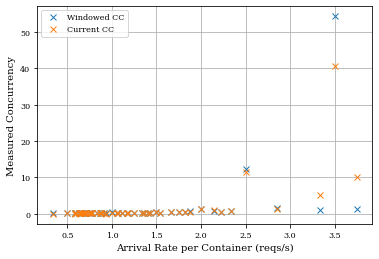

In [9]:
# let's analyze the relationship between conc_window_average and lambda_over_n
plt.plot(df_logger_merged_lon.index, df_logger_merged_lon['conc_window_average'], 'x', label='Windowed CC')
plt.plot(df_logger_merged_lon.index, df_logger_merged_lon['current_cc'], 'x', label='Current CC')
plt.xlabel('Arrival Rate per Container (reqs/s)')
plt.ylabel('Measured Concurrency')
plt.legend()
plt.grid(True)

In [10]:
# imports
from sklearn.pipeline import Pipeline
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [11]:
class CCTransformer():
    def __init__(self, columns=None, ):
        self.columns = columns
        # default columns if not provided
        if columns is None:
            self.columns = ['lon', 'cc']
        
    # here you define the operation it should perform
    def transform(self, X, y=None, **fit_params):
        cpy_df = X[self.columns].copy()
        cpy_df['lon2'] = cpy_df['lon'] ** 2
        return cpy_df

    # just return self
    def fit(self, X, y=None, **fit_params):
        return self

def cc_model_get_x_y(df_cc_orig, cc_pipe, output_col_name='cc'):
    df_cc = cc_pipe.fit_transform(df_cc_orig)
    X = df_cc[['lon', 'lon2']].values
    y = df_cc[output_col_name].values
    return X, y

def cc_model_train(df_cc, cc_pipe, output_col_name='cc', regression_options=None):
    if regression_options is None:
        regression_options = {
            'fit_intercept': False,
        }

    X,y = cc_model_get_x_y(df_cc, cc_pipe, output_col_name)
    # no intercept might be better because when lambda over n is zero, conc is zero
    regr = linear_model.LinearRegression(**regression_options)
    # Train the model using the training sets
    regr.fit(X, y)
    # get estimate for goodness of fit
    yhat = regr.predict(X)
    print('MSE:', mean_squared_error(y, yhat))
    print('R2:', r2_score(y, yhat))
    return regr

def get_linear_model_params(regr):
    # get model params
    model_params = [regr.intercept_] + list(regr.coef_)
    return model_params

def cc_get_model_predictions(plt_x, cc_pipe, cc_regr, output_col_name='cc'):
    plt_df = pd.DataFrame(data={ 'lon': plt_x, output_col_name: None })
    plt_df = cc_pipe.fit_transform(plt_df)
    test_X, test_Y = cc_model_get_x_y(plt_df, cc_pipe, output_col_name)
    plt_y = cc_regr.predict(test_X)
    return plt_y

MSE: 18.701430395315455
R2: 0.47750008765873797
Model Params: [0.0, -2.515077637905705, 1.9867598165290963]


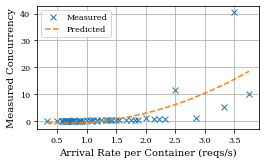

In [12]:
cc_pipe = Pipeline([
    ('cctransformer', CCTransformer())
])

df_cc = df_logger_merged_lon.reset_index().rename(columns={
    'lambda_over_n': 'lon',
    'current_cc': 'cc',
})
cc_regr = cc_model_train(df_cc, cc_pipe)
print("Model Params:", get_linear_model_params(cc_regr))

plt_x = np.linspace(df_cc['lon'].min(), df_cc['lon'].max(), 20)
plt_y = cc_get_model_predictions(plt_x, cc_pipe, cc_regr)

plt.figure(figsize=(4,2.5))
plt.plot(df_cc['lon'], df_cc['cc'], 'x', label="Measured")
plt.plot(plt_x, plt_y, label="Predicted")
plt.xlabel('Arrival Rate per Container (reqs/s)')
plt.ylabel('Measured Concurrency')
plt.legend()
plt.grid(True)
plt.gcf().subplots_adjust(left=0.13, bottom=0.20)
parse_util.tmp_fig_save('05_cc_vs_lambda_over_n_regression', exp_config_name)

# Response Time Analysis By $\lambda/N$

MSE: 26.852082149066135
R2: 0.8187523556830528
Model Params: [-6.285551480415433, 6.549359417791738, -0.2074428291735605]


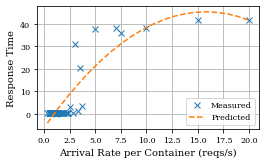

In [13]:
resp_pipe = Pipeline([
    ('cctransformer', CCTransformer(columns=['lon', 'resp']))
])

df_resp = df_reqs_merged_lon.reset_index().rename(columns={
    'lambda_over_n': 'lon',
    'resp_time_avg': 'resp',
})

resp_regr = cc_model_train(df_resp, resp_pipe, 'resp', {})
print("Model Params:", get_linear_model_params(resp_regr))

plt_x = np.linspace(df_resp['lon'].min(), df_resp['lon'].max(), 20)
plt_y = cc_get_model_predictions(plt_x, resp_pipe, resp_regr, 'resp')

plt.figure(figsize=(4,2.5))
plt.plot(df_resp['lon'], df_resp['resp'], 'x', label="Measured")
plt.plot(plt_x, plt_y, label="Predicted")
plt.xlabel('Arrival Rate per Container (reqs/s)')
plt.ylabel('Response Time')
plt.legend()
plt.grid(True)
plt.gcf().subplots_adjust(left=0.13, bottom=0.20)
parse_util.tmp_fig_save('06_resp_vs_lambda_over_n_regression', exp_config_name)